<h1>Time series Forecasting with a neural network </h1>

In [1]:
import numpy as np 
import pandas as pd 
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential
from keras import optimizers
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline


/Users/jandespiegeleer/.pyenv/versions/3.6.5/envs/seminar/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Enter in how much steps we will enroll the network.
# RNN/LSTM/GRU can be taught patterns over times series as big as the number of times you enrol them,
# and no bigger (fundamental limitation). 
# So by design these networks are deep/long to catch recurrent patterns.



In [3]:

def load_data(datasetname, column, seq_len):
    """
    datasetname: name of the dataset (pandas)
    column = name of the column to extract
    seq_len = sequence 
    normalize = True/False
    """
    
    data = datasetname.loc[:,column]

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
  
    result = np.array(result)

    
    # Last 10% is used for validation test
    # first 90% for training
    row_train = round(0.9 * result.shape[0])
    train = result[:int(row_train), :]
    np.random.seed(0)
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row_train):, :-1]
    y_test = result[int(row_train):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

In [4]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:] # remove the first point (x,y)
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0) #add the latest prediction to the set
    return predicted

In [5]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of <prediction_len> steps before shifting prediction run forward by <prediction_len> steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

    

<h2>Sin Wave Forecasting </h2>

In [6]:
# Load the data
dataset = pd.read_csv('SinWaveData.csv')
dataset.head()
dataset.shape

(5001, 1)

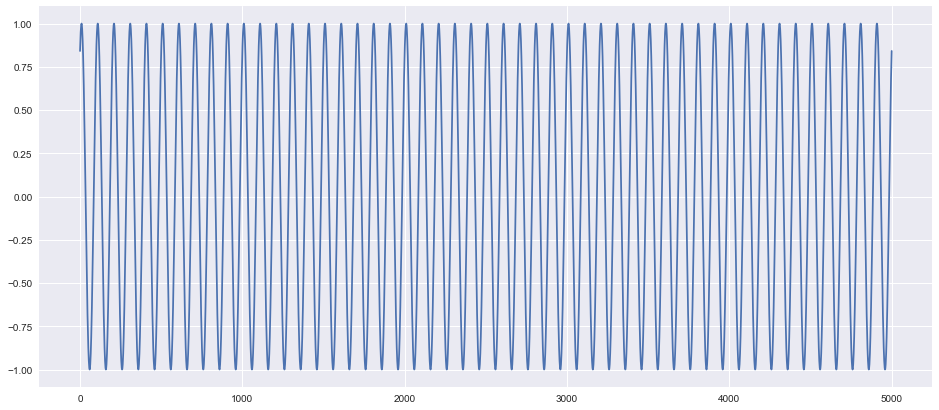

In [7]:
dataset["Wave"][:].plot(figsize=(16,7),legend=False);

In [8]:
# The label is what we are predicting (Y-axis of the wave)
# This data is already normalized
Enrol_window = 100
feature_train, label_train, feature_test, label_test = load_data(dataset, 'Wave', Enrol_window)

In [9]:
#Each row in the feature_train, corresponds to a sequence of 100 elements of the sinwave
#Each row in the label_train variable corresponds to the variable following a row in the feature train
print('Dimension of the input features')
print(feature_train.shape)
print('There are :',feature_train.shape[0],' sets, each set has ',feature_train.shape[1],' datapoints')

Dimension of the input features
(4410, 100, 1)
There are : 4410  sets, each set has  100  datapoints


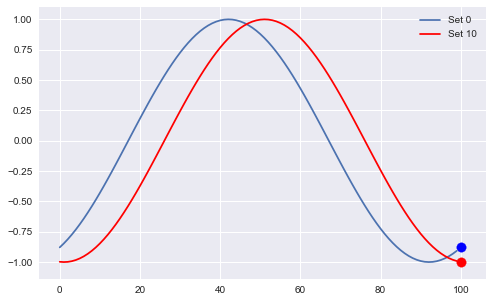

In [10]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plt.plot(feature_train[0,:,0],label='Set 0')
plt.scatter(len(feature_train[0,:,0]),label_train[0],s=90,color='b');
plt.plot(feature_train[10,:,0],color='r',label='Set 10')
plt.scatter(len(feature_train[10,:,0]),label_train[10],s=90,color='r');
plt.legend();

In [11]:
# Construct LSTM model 
model = Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))

In [12]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
model.compile(loss='mse', optimizer='adam')

In [14]:
#Train the model
model.fit(feature_train, label_train, batch_size=512, epochs=10, validation_data = (feature_test, label_test))


Train on 4410 samples, validate on 490 samples
Epoch 1/10
4410/4410 [==============================] - 8s 2ms/step - loss: 0.3032 - val_loss: 0.1417
Epoch 2/10
4410/4410 [==============================] - 6s 1ms/step - loss: 0.0859 - val_loss: 0.0401
Epoch 3/10
4410/4410 [==============================] - 6s 1ms/step - loss: 0.0202 - val_loss: 0.0055
Epoch 4/10
4410/4410 [==============================] - 6s 1ms/step - loss: 0.0109 - val_loss: 6.9155e-04
Epoch 5/10
4410/4410 [==============================] - 6s 1ms/step - loss: 0.0064 - val_loss: 0.0021
Epoch 6/10
4410/4410 [==============================] - 6s 1ms/step - loss: 0.0056 - val_loss: 4.1446e-04
Epoch 7/10
4410/4410 [==============================] - 6s 1ms/step - loss: 0.0046 - val_loss: 2.6155e-04
Epoch 8/10
4410/4410 [==============================] - 6s 1ms/step - loss: 0.0045 - val_loss: 1.7758e-04
Epoch 9/10
4410/4410 [==============================] - 6s 1ms/step - loss: 0.0042 - val_loss: 1.7784e-04
Epoch 10/10
441

In [15]:
model.predict(feature_test[0,:,0].reshape(1,100,1))[0,0]

0.99630445

In [16]:
#Let's use the model and predict the wave
# create a predictions on 100 points, 99 points + 1pred, 98 points + 2 points, etc...
predictions= predict_sequence_full(model, feature_test, Enrol_window)

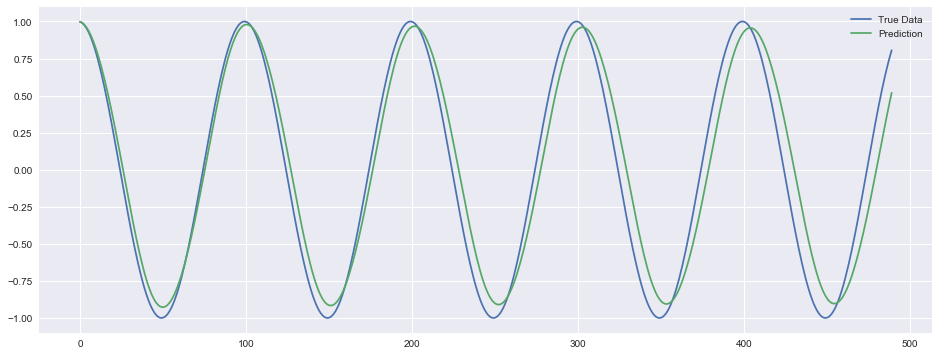

In [17]:
# plot
fig = plt.figure(figsize=(16,6)) 
plt.plot(label_test, label='True Data') 
plt.plot(predictions, label='Prediction') 
plt.legend();

<h2>Predict the stock market </h2>

In [18]:
# Let's get the stock data
dataset = pd.read_csv('AMZN.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [19]:
# Apply the same approach as in the sin wave (on the Close column)
# This time we are going to normalize the data !
feature_train, label_train, feature_test, label_test = load_data(dataset, 'Close', Enrol_window)

In [20]:
feature_train.shape

(2626, 100, 1)

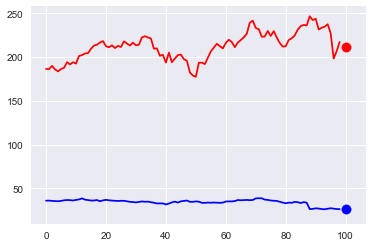

In [21]:
fig,ax = plt.subplots(1,1)
plt.plot(feature_train[0,:-1],'r')
plt.scatter(len(feature_train[0,:,0]),label_train[0],s=90,color='r');

plt.plot(feature_train[10,:-1],'b')
plt.scatter(len(feature_train[10,:,0]),label_train[10],s=90,color='b');


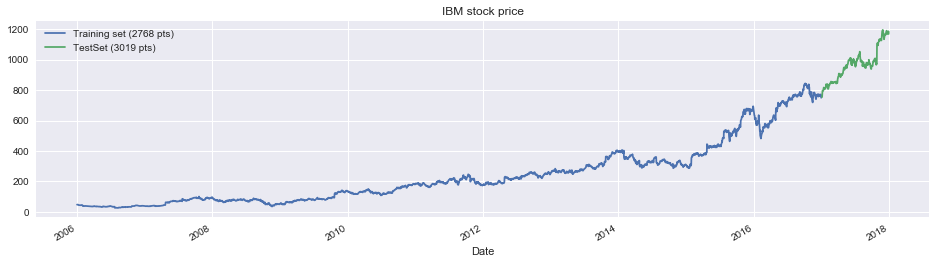

In [22]:
dataset["Close"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["Close"]['2017':].plot(figsize=(16,4),legend=True) # 10% is used for thraining data which is approx 2017 data
plt.legend(['Training set ('+str(len(dataset["Close"][:'2016'].values))+' pts)',
            'TestSet ('+str(len(dataset["Close"][:'2017'].values))+' pts)'])
plt.title('IBM stock price')
plt.show()

In [23]:
#same LSTM model as in the sinwave example
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))
model.compile(loss='mse', optimizer='adam')

In [24]:
#Train the model
model.fit(feature_train, label_train, batch_size=512, epochs=5, validation_data = (feature_test, label_test))


Train on 2626 samples, validate on 292 samples
Epoch 1/5
2626/2626 [==============================] - 5s 2ms/step - loss: 92636.3682 - val_loss: 889982.6250
Epoch 2/5
2626/2626 [==============================] - 4s 1ms/step - loss: 91446.9821 - val_loss: 884685.5625
Epoch 3/5
2626/2626 [==============================] - 5s 2ms/step - loss: 90202.6818 - val_loss: 880520.6875
Epoch 4/5
2626/2626 [==============================] - 5s 2ms/step - loss: 89167.1706 - val_loss: 875902.0625
Epoch 5/5
2626/2626 [==============================] - 4s 2ms/step - loss: 87924.2669 - val_loss: 870816.5625


In [25]:
#Let's use the model and predict the stock
predicted_stock_price = model.predict(feature_test)

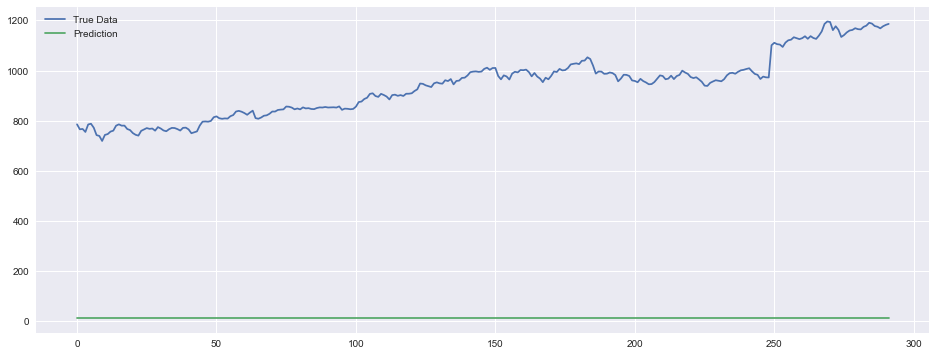

In [26]:
# plot
fig = plt.figure(figsize=(16,6)) 
plt.plot(label_test, label='True Data') 
plt.plot(predicted_stock_price, label='Prediction') 
plt.legend();

 Let's step back and actually see what we did. We created a testset of 100 (enrol_window) actual datapoints and ask to predict nr 101 (enrol window +1).Hence the fantastic result.

Like the sinewave example we need to predict a new point based on the actual last 100 points, the next point on 99 actual points and 1 prediction, the next point on 98 actuals and 2 predictions, and so forth.   
Lets make some 50 predictions ahead in the future and do this every 50 times to get a bearing how the model predicts

In [27]:
predictions = predict_sequences_multiple(model, feature_test, Enrol_window, 50)
 

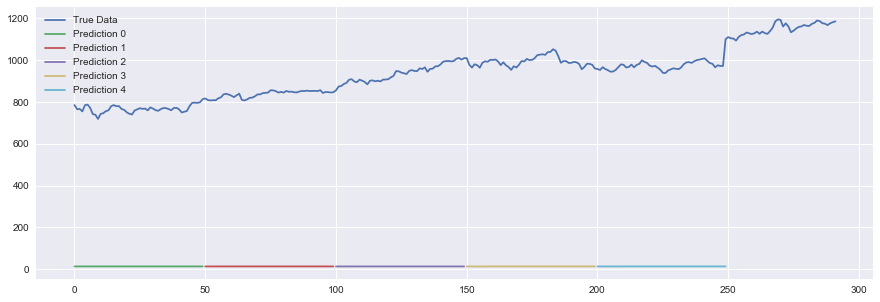

In [28]:
fig = plt.subplots(1,1,figsize=(15,5))
plt.plot(label_test, label='True Data')
for i, data in enumerate(predictions):
    padding = [None for p in range(i * 50)]
    plt.plot(padding + data, label='Prediction '+str(i))
    plt.legend()

